<a href="https://colab.research.google.com/github/KatieMarsh/STONK/blob/main/stock_prediction_LSTM_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load and preprocess data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

!pip install pandas_datareader
from pandas_datareader import data as pdr
from tqdm import tqdm_notebook

stock_list = ['SCC']
# stock_data = []
stock_data = []
stock_name = []
for quote in tqdm_notebook(stock_list):
    try:
        stock_data.append(pdr.get_data_yahoo(f'{quote}.BK', start='2010-01-01', end='2021-06-18'))
        stock_name.append(quote)
    except:
        print("Error:", sys.exc_info()[0])
        print("Description:", sys.exc_info()[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [2]:
!pip install bta-lib #try this out
import btalib
sma = btalib.sma(stock_data[0].Close, period=4)  # default period is 30, changed to 20
sma.df.columns = ['SMA_20']
sma.df.head()
stock_data = pd.concat([stock_data[0],sma.df],axis=1) # joint them together!

     |████████████████████████████████| 102kB 6.4MB/s 


In [3]:
# function สำหรับ preprocess ข้อมูล time series หลายตัวแปร
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True,feat_name=None):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{feat_name[j]}(t-{i})' for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{feat_name[j]}(t)' for j in range(n_vars)]
        else:
            names += [f'{feat_name[j]}(t+{i})' for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# เลือกข้อมูลหุ้นจาก list ของ DataFrame และ drop column 'Close' เนื่องจากเราจะใช้ column 'Adj. Close' เท่านั้น

dataset = stock_data
# dataset = stock_data[0]
dataset = dataset.drop('Close',axis=1)
# dataset = dataset.drop(dataset.index[:3])
dataset['pct_change'] = dataset['Adj Close'].pct_change().dropna()
values = dataset.values
values = values.astype('float32')
# values = values.astype('float64')



# ทำ scaling ข้อมูลด้วยวิธี min max scaling เปลี่ยน scale ข้อมูลแต่ละ column ให้อยู่ระหว่าง [0,1] และเก็บค่า min max แต่ละ column ไว้สำหรับทำ rescale ข้อมูลภายหลัง
#I think this part can be replaced with sigmoid
min_dict = dict()
max_dict = dict()
for col in dataset.columns:
  min_dict[col] = dataset[col].min()
  max_dict[col] = dataset[col].max()
  dataset[col] = (dataset[col] - dataset[col].min())/(dataset[col].max()-dataset[col].min())
  


# ใช้ function สำหรับ preprocess ข้อมูลที่เขียนไว้ และ drop column ที่ไม่ได้ใช้
reframed = series_to_supervised(dataset.values, 30, 1,feat_name=dataset.columns)

# reframed.drop(['High(t)','Low(t)','Open(t)','Volume(t)','Adj Close(t)'],
#               axis=1,inplace=True)#แก้ตรงนี้

reframed.drop(['High(t)','Low(t)','Open(t)','Volume(t)','Adj Close(t)','SMA_20(t)'],
              axis=1,inplace=True)#แก้ตรงนี้

# for i in range(1, 30, 1):
#     reframed.drop([f'High(t+{i})',f'Low(t+{i})',f'Open(t+{i})',f'Volume(t+{i})',f'Adj Close(t+{i})'],
#               axis=1,inplace=True)




In [4]:
import time

In [5]:
dataset.tail(5)

,High,Low,Open,Volume,Adj Close,SMA_20,pct_change
Date,,,,,,,
2021-06-14,0.636364,0.629851,0.644970,0.031789,0.855912,0.636092,0.403261
2021-06-15,0.618768,0.623881,0.621302,0.047357,0.837901,0.633110,0.365719
2021-06-16,0.624633,0.623881,0.615385,0.026764,0.843904,0.631618,0.440896
2021-06-17,0.612903,0.611940,0.615385,0.041961,0.831897,0.624161,0.384092
2021-06-18,0.618768,0.611940,0.609467,0.050477,0.843904,0.621178,0.460072


In [6]:
reframed.head(10)

,High(t-30),Low(t-30),Open(t-30),Volume(t-30),Adj Close(t-30),SMA_20(t-30),pct_change(t-30),High(t-29),Low(t-29),Open(t-29),Volume(t-29),Adj Close(t-29),SMA_20(t-29),pct_change(t-29),High(t-28),Low(t-28),Open(t-28),Volume(t-28),Adj Close(t-28),SMA_20(t-28),pct_change(t-28),High(t-27),Low(t-27),Open(t-27),Volume(t-27),Adj Close(t-27),SMA_20(t-27),pct_change(t-27),High(t-26),Low(t-26),Open(t-26),Volume(t-26),Adj Close(t-26),SMA_20(t-26),pct_change(t-26),High(t-25),Low(t-25),Open(t-25),Volume(t-25),Adj Close(t-25),SMA_20(t-25),pct_change(t-25),High(t-24),Low(t-24),Open(t-24),Volume(t-24),Adj Close(t-24),SMA_20(t-24),pct_change(t-24),High(t-23),Low(t-23),Open(t-23),Volume(t-23),Adj Close(t-23),SMA_20(t-23),pct_change(t-23),High(t-22),Low(t-22),Open(t-22),Volume(t-22),Adj Close(t-22),SMA_20(t-22),pct_change(t-22),High(t-21),Low(t-21),Open(t-21),Volume(t-21),Adj Close(t-21),SMA_20(t-21),pct_change(t-21),High(t-20),Low(t-20),Open(t-20),Volume(t-20),Adj Close(t-20),SMA_20(t-20),pct_change(t-20),High(t-19),Low(t-19),Open(t-19),Volume(t-19),Adj Close(t-19),SMA_20(t-19),pct_change(t-19),High(t-18),Low(t-18),Open(t-18),Volume(t-18),Adj Close(t-18),SMA_20(t-18),pct_change(t-18),High(t-17),Low(t-17),Open(t-17),Volume(t-17),Adj Close(t-17),SMA_20(t-17),pct_change(t-17),High(t-16),Low(t-16),Open(t-16),Volume(t-16),Adj Close(t-16),SMA_20(t-16),pct_change(t-16),High(t-15),Low(t-15),Open(t-15),Volume(t-15),Adj Close(t-15),SMA_20(t-15),pct_change(t-15),High(t-14),Low(t-14),Open(t-14),Volume(t-14),Adj Close(t-14),SMA_20(t-14),pct_change(t-14),High(t-13),Low(t-13),Open(t-13),Volume(t-13),Adj Close(t-13),SMA_20(t-13),pct_change(t-13),High(t-12),Low(t-12),Open(t-12),Volume(t-12),Adj Close(t-12),SMA_20(t-12),pct_change(t-12),High(t-11),Low(t-11),Open(t-11),Volume(t-11),Adj Close(t-11),SMA_20(t-11),pct_change(t-11),High(t-10),Low(t-10),Open(t-10),Volume(t-10),Adj Close(t-10),SMA_20(t-10),pct_change(t-10),High(t-9),Low(t-9),Open(t-9),Volume(t-9),Adj Close(t-9),SMA_20(t-9),pct_change(t-9),High(t-8),Low(t-8),Open(t-8),Volume(t-8),Adj Close(t-8),SMA_20(t-8),pct_change(t-8),High(t-7),Low(t-7),Open(t-7),Volume(t-7),Adj Close(t-7),SMA_20(t-7),pct_change(t-7),High(t-6),Low(t-6),Open(t-6),Volume(t-6),Adj Close(t-6),SMA_20(t-6),pct_change(t-6),High(t-5),Low(t-5),Open(t-5),Volume(t-5),Adj Close(t-5),SMA_20(t-5),pct_change(t-5),High(t-4),Low(t-4),Open(t-4),Volume(t-4),Adj Close(t-4),SMA_20(t-4),pct_change(t-4),High(t-3),Low(t-3),Open(t-3),Volume(t-3),Adj Close(t-3),SMA_20(t-3),pct_change(t-3),High(t-2),Low(t-2),Open(t-2),Volume(t-2),Adj Close(t-2),SMA_20(t-2),pct_change(t-2),High(t-1),Low(t-1),Open(t-1),Volume(t-1),Adj Close(t-1),SMA_20(t-1),pct_change(t-1),pct_change(t)
33,0.052786,0.041791,0.056213,0.043635,0.030062,0.054437,0.352528,0.049853,0.041791,0.041420,0.069470,0.032066,0.049963,0.439551,0.067449,0.050746,0.047337,0.097251,0.050104,0.052200,0.580051,0.064516,0.056716,0.065089,0.043628,0.040083,0.052946,0.337389,0.061584,0.053731,0.050296,0.041156,0.044091,0.058166,0.456438,0.061584,0.059701,0.065089,0.019212,0.040083,0.061148,0.387661,0.058651,0.050746,0.059172,0.041287,0.034070,0.055183,0.370099,0.046921,0.044776,0.047337,0.029498,0.032066,0.052200,0.404406,0.043988,0.038806,0.044379,0.040444,0.028058,0.046234,0.386756,0.041056,0.032836,0.041420,0.025183,0.028058,0.041760,0.421901,0.035191,0.029851,0.035503,0.021979,0.022046,0.037286,0.368715,0.035191,0.023881,0.026627,0.032565,0.028058,0.035794,0.475805,0.020528,0.014925,0.023669,0.076777,0.010021,0.029083,0.262347,0.017595,0.014925,0.014793,0.020098,0.012025,0.023117,0.440366,0.023460,0.011940,0.017751,0.049920,0.008017,0.017897,0.385137,0.020528,0.011940,0.017751,0.038898,0.012025,0.011931,0.459007,0.017595,0.011940,0.014793,0.024625,0.014029,0.013423,0.440283,0.017595,0.008955,0.011834,0.022644,0.014029,0.014169,0.421901,0.017595,0.011940,0.020710,0.039198,0.008017,0.014169,0.367008,0.014663,0.011940,0.011834,0.046097,0.012025,0.014169,0.459007,0.014663,0.014925,0.014793,0.008636,0.012025,0.013423,0

In [7]:
# split into train and test sets
n_train_percent = 0.9
split = int(reframed.shape[0]*n_train_percent)
df_seq_train = reframed.iloc[:split, :]
df_seq_test = reframed.iloc[split:, :]

date_all = dataset.index[reframed.index]

## Extract features from datetime

In [8]:
df_dt = pd.DataFrame({'date_time':date_all})

In [9]:
df_dt_feat = pd.concat([df_dt.date_time.dt.day, df_dt.date_time.dt.dayofweek, df_dt.date_time.dt.dayofyear,\
                           df_dt.date_time.dt.daysinmonth, df_dt.date_time.dt.is_month_end,df_dt.date_time.dt.is_month_start,\
                           df_dt.date_time.dt.is_quarter_end, df_dt.date_time.dt.is_quarter_start, df_dt.date_time.dt.is_year_end,\
                           df_dt.date_time.dt.is_year_start],axis=1)
df_dt_feat.columns = ['day','dayofweek','dayofyear','daysinmonth','is_month_end','is_month_start','is_quarter_end','is_quarter_start',\
                        'is_year_end','is_year_start']

In [10]:
df_dt_feat['is_month_end'] = df_dt_feat['is_month_end'].astype(int)
df_dt_feat['is_month_start'] = df_dt_feat['is_month_start'].astype(int)
df_dt_feat['is_quarter_end'] = df_dt_feat['is_quarter_end'].astype(int)
df_dt_feat['is_quarter_start'] = df_dt_feat['is_quarter_start'].astype(int)
df_dt_feat['is_year_end'] = df_dt_feat['is_year_end'].astype(int)
df_dt_feat['is_year_start'] = df_dt_feat['is_year_start'].astype(int)

In [11]:
# encode categorical columns
for col in ['day','dayofweek','dayofyear','daysinmonth']:
  df_dt_feat[col] = df_dt_feat[col].astype('category').cat.as_ordered().cat.codes

In [12]:
df_dt_feat.head()

,day,dayofweek,dayofyear,daysinmonth,is_month_end,is_month_start,is_quarter_end,is_quarter_start,is_year_end,is_year_start
0,17,3,47,0,0,0,0,0,0,0
1,18,4,48,0,0,0,0,0,0,0
2,21,0,51,0,0,0,0,0,0,0
3,22,1,52,0,0,0,0,0,0,0
4,23,2,53,0,0,0,0,0,0,0


In [13]:
df_dt_feat_train = df_dt_feat.iloc[:split]
df_dt_feat_test = df_dt_feat.iloc[split:]

# **PYTORCH PART**<BR>
**  CREDIT:** Thanks to **Charin Polpanumas** for his tutorial on Recommendation system using Pytorch. Most of this Pytorch part is adapted from his original code.

## Dataset & Dataloader



In [14]:
#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
device

device(type='cuda', index=0)

In [16]:
class StockDataset(Dataset):
  def __init__(self, df_seq, feat_num, seq_len, target_len, df_cat):
    # SEQUENTIAL PART
    self.df_seq = df_seq.iloc[:,:-target_len]
    self.df_cat = df_cat
    self.target = df_seq.iloc[:,-target_len:]
    
  def __getitem__(self, index):
    return(torch.tensor(self.df_seq.iloc[index].values.reshape(seq_len,feat_num), dtype=torch.float, device=device),
           torch.tensor(self.df_cat.iloc[index], dtype=torch.long, device=device),
           torch.tensor(self.target.iloc[index], dtype=torch.float, device=device))
  
  def __len__(self):
    return(self.df_seq.shape[0])
    

feat_num = 7 # จำนวน feat
seq_len = 30 # ข้อมูล 30 วัน
target_len = 1

bs = 64
train_ds = StockDataset(df_seq_train, feat_num, seq_len, target_len, df_dt_feat_train) #df_seq_train ลองไปดูถ้าต้องเพิ่มน่าจะตรงนี้
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
test_ds = StockDataset(df_seq_test, feat_num, seq_len, target_len, df_dt_feat_test)
test_dl = DataLoader(test_ds, batch_size=len(test_ds), shuffle=False)

In [17]:
next(iter(train_dl))[0]

tensor([[[0.0528, 0.0418, 0.0562,  ..., 0.0301, 0.0544, 0.3525],
         [0.0499, 0.0418, 0.0414,  ..., 0.0321, 0.0500, 0.4396],
         [0.0674, 0.0507, 0.0473,  ..., 0.0501, 0.0522, 0.5801],
         ...,
         [0.0029, 0.0000, 0.0030,  ..., 0.0020, 0.0022, 0.3846],
         [0.0000, 0.0000, 0.0000,  ..., 0.0020, 0.0022, 0.4219],
         [0.0059, 0.0060, 0.0030,  ..., 0.0040, 0.0015, 0.4407]],

        [[0.0499, 0.0418, 0.0414,  ..., 0.0321, 0.0500, 0.4396],
         [0.0674, 0.0507, 0.0473,  ..., 0.0501, 0.0522, 0.5801],
         [0.0645, 0.0567, 0.0651,  ..., 0.0401, 0.0529, 0.3374],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0020, 0.0022, 0.4219],
         [0.0059, 0.0060, 0.0030,  ..., 0.0040, 0.0015, 0.4407],
         [0.0029, 0.0000, 0.0030,  ..., 0.0020, 0.0000, 0.4032]],

        [[0.0674, 0.0507, 0.0473,  ..., 0.0501, 0.0522, 0.5801],
         [0.0645, 0.0567, 0.0651,  ..., 0.0401, 0.0529, 0.3374],
         [0.0616, 0.0537, 0.0503,  ..., 0.0441, 0.0582, 0.

In [18]:
next(iter(train_dl))[1]

tensor([[ 17,   3,  47,   0,   0,   0,   0,   0,   0,   0],
        [ 18,   4,  48,   0,   0,   0,   0,   0,   0,   0],
        [ 21,   0,  51,   0,   0,   0,   0,   0,   0,   0],
        [ 22,   1,  52,   0,   0,   0,   0,   0,   0,   0],
        [ 23,   2,  53,   0,   0,   0,   0,   0,   0,   0],
        [ 24,   3,  54,   0,   0,   0,   0,   0,   0,   0],
        [ 25,   4,  55,   0,   0,   0,   0,   0,   0,   0],
        [  1,   1,  59,   3,   0,   0,   0,   0,   0,   0],
        [  2,   2,  60,   3,   0,   0,   0,   0,   0,   0],
        [  3,   3,  61,   3,   0,   0,   0,   0,   0,   0],
        [  4,   4,  62,   3,   0,   0,   0,   0,   0,   0],
        [  7,   0,  65,   3,   0,   0,   0,   0,   0,   0],
        [  8,   1,  66,   3,   0,   0,   0,   0,   0,   0],
        [  9,   2,  67,   3,   0,   0,   0,   0,   0,   0],
        [ 10,   3,  68,   3,   0,   0,   0,   0,   0,   0],
        [ 11,   4,  69,   3,   0,   0,   0,   0,   0,   0],
        [ 14,   0,  72,   3,   0,   0,  

In [19]:
next(iter(train_dl))[2]

tensor([[0.4032],
        [0.5160],
        [0.4219],
        [0.4770],
        [0.4219],
        [0.4763],
        [0.4219],
        [0.5471],
        [0.4392],
        [0.4219],
        [0.3874],
        [0.3696],
        [0.4396],
        [0.4219],
        [0.4570],
        [0.4567],
        [0.4219],
        [0.4737],
        [0.5242],
        [0.3887],
        [0.4554],
        [0.4884],
        [0.4873],
        [0.4219],
        [0.4702],
        [0.3901],
        [0.3899],
        [0.5349],
        [0.4690],
        [0.6082],
        [0.4516],
        [0.5102],
        [0.3779],
        [0.2588],
        [0.4992],
        [0.2551],
        [0.1845],
        [0.4219],
        [0.7753],
        [0.4528],
        [0.4066],
        [0.4065],
        [0.5301],
        [0.3918],
        [0.3461],
        [0.4528],
        [0.4833],
        [0.5730],
        [0.3054],
        [0.3319],
        [0.4986],
        [0.3466],
        [0.4219],
        [0.3452],
        [0.4375],
        [0

In [20]:
print(next(iter(train_dl))[0].shape)
print(next(iter(train_dl))[1].shape)
print(next(iter(train_dl))[2].shape)

torch.Size([64, 30, 7])
torch.Size([64, 10])
torch.Size([64, 1])


## **Architecture**

In [21]:
config = {'rnn_p':0., 'rnn_l':1, 'rnn_h':1000, 'seq_len':seq_len, 'rnn_input_dim':feat_num, #จำนวน feat ปัจจุบัน ให้ลอง mod ดู
          'fc_szs':[1000, 500],'fc_ps':[0.5, 0.25], 'out_sz':target_len,
          'emb_p':0.05}
cat_dict = {'day':31,'dayofweek':5,'dayofyear':366,'daysinmonth':4,'is_month_end':2,
            'is_month_start':2,'is_quarter_end':2,'is_quarter_start':2,'is_year_end':2,'is_year_start':2}
  
# lazy embedding size rule!
def emb_sz_rule(n_cat): return min(50,n_cat)


class StockPredictor(nn.Module):
  def __init__(self,config,cat_size):
    super(StockPredictor, self).__init__()
    # set parameters
    self.rnn_p = config['rnn_p']
    self.rnn_l = config['rnn_l']
    self.rnn_h = config['rnn_h']
    self.seq_len = config['seq_len']
    self.fc_szs = config['fc_szs']
    self.fc_ps = config['fc_ps']
    self.out_sz = config['out_sz']
    self.cat_size = cat_size
    self.emb_p  = config['emb_p']
    
    # embedding layers for categorical features
    self.emb_drop = nn.Dropout(self.emb_p)
    self.cat_layers = nn.ModuleList([nn.Embedding(val,emb_sz_rule(val)) for val in cat_size.values()])
    self.lin_in = sum([emb_sz_rule(val) for val in cat_size.values()]) + self.rnn_h*self.seq_len
    self.fc_szs = [self.lin_in] + self.fc_szs
    
    # recurrent layers
    self.rnn_layers = nn.LSTM(config['rnn_input_dim'], self.rnn_h, num_layers=self.rnn_l,
                             bias=True, batch_first=True, dropout=self.rnn_p)
    
    # fully connected layers
    fc_layers_list = []
    for ni, nf, p in zip(self.fc_szs[:-1], self.fc_szs[1:], self.fc_ps):
      fc_layers_list.append(nn.Linear(ni, nf))
      fc_layers_list.append(nn.ReLU(inplace=True))
      fc_layers_list.append(nn.BatchNorm1d(nf))
      fc_layers_list.append(nn.Dropout(p=p))
    self.fc_layers = nn.Sequential(*fc_layers_list)
    
    # output
    self.out = torch.nn.Linear(in_features=self.fc_szs[-1], out_features=self.out_sz)
    
  def forward(self, seq_input, cat_input):
    # cat
    cat_list = [e(cat_input[:,i]) for i,e in enumerate(self.cat_layers)]
    cat_out = torch.cat(cat_list,1)
    cat_out = self.emb_drop(cat_out)
    
    # seq
    bs = seq_input.shape[0]
    seq_out, seq_h = self.rnn_layers(seq_input)
    seq_out = seq_out.contiguous()
    seq_out = seq_out.view(bs,-1)
    
    #linear
    lin_in = torch.cat([cat_out, seq_out],1)
    res = self.fc_layers(lin_in)
    res = self.out(res)
    
    return res

In [22]:
model = StockPredictor(config,cat_dict).to(device)
x = next(iter(train_dl))
seq_input = x[0]
cat_input = x[1]
model(seq_input, cat_input).shape

torch.Size([64, 1])

In [23]:
seq_input

tensor([[[0.0528, 0.0418, 0.0562,  ..., 0.0301, 0.0544, 0.3525],
         [0.0499, 0.0418, 0.0414,  ..., 0.0321, 0.0500, 0.4396],
         [0.0674, 0.0507, 0.0473,  ..., 0.0501, 0.0522, 0.5801],
         ...,
         [0.0029, 0.0000, 0.0030,  ..., 0.0020, 0.0022, 0.3846],
         [0.0000, 0.0000, 0.0000,  ..., 0.0020, 0.0022, 0.4219],
         [0.0059, 0.0060, 0.0030,  ..., 0.0040, 0.0015, 0.4407]],

        [[0.0499, 0.0418, 0.0414,  ..., 0.0321, 0.0500, 0.4396],
         [0.0674, 0.0507, 0.0473,  ..., 0.0501, 0.0522, 0.5801],
         [0.0645, 0.0567, 0.0651,  ..., 0.0401, 0.0529, 0.3374],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0020, 0.0022, 0.4219],
         [0.0059, 0.0060, 0.0030,  ..., 0.0040, 0.0015, 0.4407],
         [0.0029, 0.0000, 0.0030,  ..., 0.0020, 0.0000, 0.4032]],

        [[0.0674, 0.0507, 0.0473,  ..., 0.0501, 0.0522, 0.5801],
         [0.0645, 0.0567, 0.0651,  ..., 0.0401, 0.0529, 0.3374],
         [0.0616, 0.0537, 0.0503,  ..., 0.0441, 0.0582, 0.

In [24]:
model

StockPredictor(
  (emb_drop): Dropout(p=0.05, inplace=False)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(7, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=30102, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)

## **Training**

In [25]:
from copy import deepcopy
model = StockPredictor(config, cat_dict).to(device)
loss_function = nn.L1Loss()
# loss_function = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1)

train_losses = []
test_losses = []
lrs = []
best_loss = np.inf
best_weights = None
no_improvements = 0
n_epoch = 40

for epoch in tqdm_notebook(range(n_epoch)):
  
  # current lr
  lr = scheduler.optimizer.param_groups[0]['lr']
  lrs.append(lr)
  
  # train
  train_loss = []
  model.train()
  for x in train_dl:
    seq_input = x[0]
    cat_input = x[1]
    target = x[2]
    
    # forward
    pred = model(seq_input,cat_input)
    
    # loss
    loss = loss_function(pred,target)
    train_loss.append(loss.item())
  
    # step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  train_losses.append(np.mean(train_loss))
  
  # validate
  model.eval()
  for x in test_dl:
    seq_input = x[0]
    cat_input = x[1]
    target = x[2]
    
    # forward
    pred = model(seq_input,cat_input)
    
    # loss
    test_loss = loss_function(pred,target)
    test_losses.append(test_loss.item())
    
  # choose best model
  if test_loss < best_loss:
    best_loss = test_loss
    best_weights = deepcopy(model.state_dict())
  else:
    no_improvements +=1
  
  # early stopping
#  if no_improvements > 5:
#    print(f'early stopping after epoch {epoch}')
#    break
    
  #end of epoch
  scheduler.step(test_loss)
  print(f'{epoch} train loss: {round(np.mean(train_loss),3)} test loss: {round(test_loss.item(),3)}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


0 train loss: 0.477 test loss: 5.25
1 train loss: 0.231 test loss: 0.261
2 train loss: 0.178 test loss: 0.166
3 train loss: 0.263 test loss: 0.837
4 train loss: 0.123 test loss: 0.791
5 train loss: 0.101 test loss: 0.048
6 train loss: 0.091 test loss: 0.183
7 train loss: 0.089 test loss: 0.286
8 train loss: 0.084 test loss: 0.111
9 train loss: 0.084 test loss: 0.059
10 train loss: 0.086 test loss: 0.078
11 train loss: 0.085 test loss: 0.065
12 train loss: 0.085 test loss: 0.065
13 train loss: 0.084 test loss: 0.072
14 train loss: 0.084 test loss: 0.082
15 train loss: 0.085 test loss: 0.066
16 train loss: 0.084 test loss: 0.068
17 train loss: 0.087 test loss: 0.073
18 train loss: 0.088 test loss: 0.072
19 train loss: 0.085 test loss: 0.054
20 train loss: 0.084 test loss: 0.065
21 train loss: 0.087 test loss: 0.07
22 train loss: 0.087 test loss: 0.054
23 train loss: 0.085 test loss: 0.067
24 train loss: 0.084 test loss: 0.087
25 train loss: 0.083 test loss: 0.059
26 train loss: 0.085 tes

In [26]:
test_dl

## **Diagnostics**

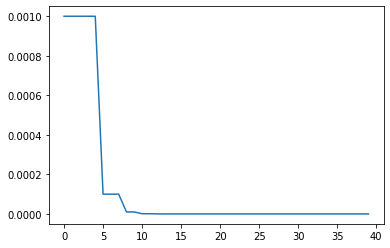

In [27]:
plt.plot(lrs)

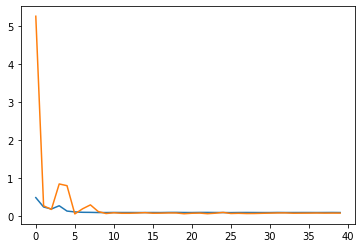

In [28]:
plt.plot(train_losses)
plt.plot(test_losses)

In [29]:
torch.save(best_weights, 'best_weights.pth')
model = StockPredictor(config, cat_dict).to(device)
model.load_state_dict(torch.load('best_weights.pth'))
model.eval()

StockPredictor(
  (emb_drop): Dropout(p=0.05, inplace=False)
  (cat_layers): ModuleList(
    (0): Embedding(31, 31)
    (1): Embedding(5, 5)
    (2): Embedding(366, 50)
    (3): Embedding(4, 4)
    (4): Embedding(2, 2)
    (5): Embedding(2, 2)
    (6): Embedding(2, 2)
    (7): Embedding(2, 2)
    (8): Embedding(2, 2)
    (9): Embedding(2, 2)
  )
  (rnn_layers): LSTM(7, 1000, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=30102, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
  )
  (out): Linear(in_features=500, out_features=1, bias=True)
)

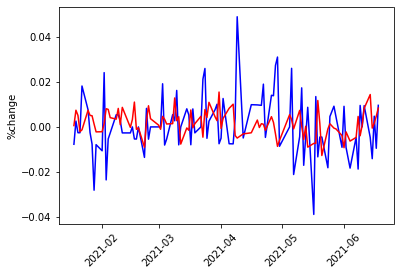

In [30]:
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
date_test = date_all[split:]

_=plt.plot(date_test[-100:],inv_true_pct.cpu().detach().numpy()[-100:],'b')
_=plt.plot(date_test[-100:],inv_pred_pct.cpu().detach().numpy()[-100:],'r')
_=plt.xticks(rotation=45)
_=plt.ylabel('%change')

In [31]:
target

tensor([[0.3847],
        [0.5344],
        [0.3976],
        [0.3852],
        [0.5083],
        [0.5307],
        [0.4337],
        [0.4923],
        [0.3297],
        [0.3511],
        [0.4700],
        [0.4575],
        [0.4572],
        [0.3986],
        [0.4336],
        [0.3634],
        [0.4575],
        [0.4925],
        [0.4450],
        [0.4104],
        [0.3643],
        [0.4453],
        [0.4103],
        [0.4102],
        [0.3283],
        [0.5417],
        [0.3986],
        [0.5623],
        [0.5010],
        [0.5105],
        [0.3677],
        [0.4659],
        [0.4762],
        [0.3361],
        [0.3562],
        [0.3885],
        [0.4893],
        [0.4550],
        [0.3890],
        [0.3888],
        [0.3996],
        [0.4555],
        [0.3552],
        [0.5123],
        [0.4992],
        [0.3894],
        [0.4547],
        [0.4653],
        [0.6149],
        [0.4219],
        [0.3196],
        [0.4114],
        [0.4535],
        [0.4323],
        [0.4011],
        [0

In [32]:
# convert to price plot
seq_input,cat_input,target = next(iter(test_dl))

# model output
pred_pct = model(seq_input,cat_input)
inv_pred_pct = pred_pct*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']

# to get real price is to multiply the predicted % with previous day close price


#prev_day_close is the current bug something went wrong in this line
prev_day_close = seq_input[:,-1,-2]*(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
#(max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close'] THIS PART IS CORRECT



pred_price = (1+inv_pred_pct.view(-1,))*prev_day_close

inv_true_pct = target*(max_dict['pct_change']-min_dict['pct_change'])+min_dict['pct_change']
true_price = (1+inv_true_pct.view(-1,))*prev_day_close

In [33]:
yeah = (max_dict['Adj Close']-min_dict['Adj Close'])+min_dict['Adj Close']
yeah

474.0

In [34]:
prev_day_close[-1]

tensor(348.7972, device='cuda:0')

In [35]:
print(seq_input[:,-1,-2])

tensor([0.3259, 0.3229, 0.3333, 0.3326, 0.3333, 0.3415, 0.3497, 0.3602, 0.3773,
        0.3833, 0.3781, 0.3751, 0.3699, 0.3729, 0.3788, 0.3826, 0.3803, 0.3781,
        0.3818, 0.3863, 0.3937, 0.3952, 0.3937, 0.3900, 0.3863, 0.3803, 0.3803,
        0.3796, 0.3885, 0.4087, 0.4273, 0.4437, 0.4541, 0.4631, 0.4601, 0.4564,
        0.4474, 0.4392, 0.4392, 0.4415, 0.4437, 0.4400, 0.4362, 0.4303, 0.4325,
        0.4415, 0.4459, 0.4571, 0.4653, 0.4817, 0.5004, 0.5093, 0.5145, 0.5086,
        0.5034, 0.5041, 0.5078, 0.5108, 0.5123, 0.5153, 0.5198, 0.5227, 0.5242,
        0.5265, 0.5205, 0.5153, 0.5063, 0.5019, 0.4952, 0.4855, 0.4884, 0.4862,
        0.4892, 0.4952, 0.4922, 0.4862, 0.4765, 0.4691, 0.4668, 0.4616, 0.4571,
        0.4504, 0.4422, 0.4362, 0.4310, 0.4228, 0.4094, 0.4079, 0.4124, 0.4280,
        0.4474, 0.4579, 0.4638, 0.4489, 0.4325, 0.4161, 0.4004, 0.3967, 0.3915,
        0.3863, 0.3766, 0.3661, 0.3594, 0.3475, 0.3400, 0.3356, 0.3304, 0.3296,
        0.3415, 0.3512, 0.3609, 0.3796, 

In [36]:
print(max_dict)

{'High': 554.0, 'Low': 546.0, 'Open': 550.0, 'Volume': 41989400.0, 'Adj Close': 474.0, 'SMA_20': 547.5, 'pct_change': 0.14492769415845852}


In [37]:
print(min_dict)

{'High': 213.0, 'Low': 211.0, 'Open': 212.0, 'Volume': 0.0, 'Adj Close': 140.8712615966797, 'SMA_20': 212.25, 'pct_change': -0.10576925568546891}


In [38]:

F.mse_loss(true_price,pred_price).sqrt()

tensor(4.6866, device='cuda:0', grad_fn=<SqrtBackward>)

In [39]:
pred_price

tensor([251.6997, 252.7137, 255.8161, 254.2639, 253.6155, 257.2312, 259.3212,
        263.8496, 271.8783, 272.2474, 269.6181, 267.2023, 265.9294, 268.3044,
        270.1880, 269.9274, 270.2239, 271.2842, 269.9113, 273.3705, 272.9135,
        275.9617, 275.2893, 274.5881, 273.8471, 268.5267, 269.0742, 270.1608,
        274.3312, 279.5096, 284.1336, 291.1211, 294.2909, 296.2086, 293.7251,
        292.2919, 291.7608, 289.0296, 286.8299, 290.0353, 290.6477, 289.0113,
        287.5836, 285.6384, 285.4394, 287.3623, 289.6652, 296.3792, 298.5577,
        302.3698, 310.4864, 315.0557, 315.2784, 311.2998, 310.5431, 307.7101,
        312.4091, 312.7791, 310.1544, 314.7881, 314.1034, 318.4256, 317.3612,
        316.5800, 315.4790, 314.9677, 310.0069, 308.0432, 309.1953, 304.9797,
        306.2716, 305.0288, 305.3665, 306.9298, 307.6786, 302.1418, 300.6073,
        295.1594, 300.7759, 295.5564, 294.6883, 292.1239, 290.7365, 289.7781,
        285.1379, 282.9750, 278.3951, 276.5209, 279.0009, 283.14

In [40]:
true_price

tensor([247.1061, 255.4455, 250.3781, 249.3498, 257.3736, 261.5916, 258.1386,
        265.4606, 260.4074, 263.7909, 270.0339, 268.1990, 266.4237, 263.5301,
        267.8532, 264.3756, 269.9535, 271.5418, 269.6153, 268.7751, 268.1049,
        274.1313, 271.2430, 270.0021, 263.2281, 275.5995, 266.0044, 276.7231,
        275.6571, 283.1601, 279.3668, 291.8611, 296.1382, 288.7918, 289.2968,
        290.4487, 294.8222, 289.5761, 284.8226, 285.5420, 287.0673, 289.8602,
        281.4127, 290.6495, 290.4792, 285.5875, 291.8041, 296.3380, 310.2011,
        301.3494, 299.6737, 309.7236, 314.7517, 311.1047, 306.9422, 311.2334,
        311.6588, 310.2319, 311.5345, 316.5870, 314.0187, 312.5892, 316.3245,
        311.3640, 315.0898, 306.0002, 315.3254, 300.7987, 303.3612, 309.9518,
        303.5851, 301.2418, 304.6395, 303.3938, 306.0647, 297.1259, 302.9029,
        300.3559, 290.0072, 289.7853, 293.9705, 292.5365, 284.1918, 282.1763,
        282.0257, 277.6766, 286.1443, 279.1014, 287.5993, 283.46

In [41]:
# stock_data[0][["Close"]].tail(10)

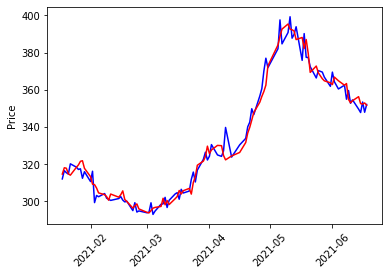

In [42]:
#graph of predicted and true closing price
_=plt.plot(date_test[-100:],true_price.cpu().detach().numpy()[-100:],'b') #True
_=plt.plot(date_test[-100:],pred_price.cpu().detach().numpy()[-100:],'r') #Predict
_=plt.xticks(rotation=45)
_=plt.ylabel('Price')

In [43]:
np.corrcoef(true_price.cpu().detach().numpy(),pred_price.cpu().detach().numpy())[0][1]

0.9900692046186788

# **Simulation**

In [44]:
cash = 1_000_000
port = 0
for pct_pred, pct_true in zip(inv_pred_pct.cpu().detach().numpy(),inv_true_pct.cpu().detach().numpy()):
  if pct_pred>0:
    #buy
    if port == 0:
      port=cash
      cash=0
  else:
    #sell
    if port != 0:
      cash=port
      port=0
  #realize
  if port != 0:
    port *= (1+pct_true)
  
equity = cash+port
print(equity)

[1583682.28744065]


In [45]:
min(date_test), max(date_test)

(Timestamp('2020-04-21 00:00:00'), Timestamp('2021-06-18 00:00:00'))

# **The added stuffs**

## SMA using pandas and numpy




In [46]:
#  df1 = stock_data[0]

In [47]:
#SMA20 AKA simple moving average (20days) with numpy and pandas
# for i in range(0,df1.shape[0]-19):
#     df1.loc[df1.index[i+19],'SMA_20'] = np.round(((df1.iloc[i,3]+ df1.iloc[i+1,3]    
#                                                  + df1.iloc[i+2,3] + df1.iloc[i+3,3] 
#                                                  + df1.iloc[i+4,3] + df1.iloc[i+5,3]
#                                                  + df1.iloc[i+6,3] + df1.iloc[i+7,3]
#                                                  + df1.iloc[i+8,3] + df1.iloc[i+9,3]
#                                                  + df1.iloc[i+10,3] + df1.iloc[i+11,3]
#                                                  + df1.iloc[i+12,3] + df1.iloc[i+13,3]
#                                                  + df1.iloc[i+14,3] + df1.iloc[i+15,3]
#                                                  + df1.iloc[i+16,3] + df1.iloc[i+17,3]
#                                                  + df1.iloc[i+18,3] + df1.iloc[i+19,3]
#                                                  )/20),1)

In [48]:
#  df1.tail(20)

In [49]:
#  df1[['Close','SMA_20']].plot()

In [50]:
# #comparing SMA price to current price to decide what to do
# if df1.iloc[-1,6] > df1.iloc[-1,3]:
#   print("Current price is below SMA20 might be a good time to buy and hold long")

# elif df1.iloc[-1,6] == df1.iloc[-1,3]:
#   print("Current price is exactly the same as SMA20 take a look at the day before to see if the price in coming from above or below ")

# else:
#   print("Current price is above SMA20 might want to wait a while before buying")
# print("SMA20 = ", df1.iloc[-1,6])
# print("Current price = ", df1.iloc[-1,3])

## The part with SMA